In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse

import sys
sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast



In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import zarr
from zarr.storage import ZipStore
from scipy.sparse import csc_matrix

base = "/Volumes/processing2/KaroSpaceDataWrangle/raw/Xenium_V1_mouse_pup_xe_outs"
mat_zip = f"{base}/cell_feature_matrix.zarr.zip"
cells_zip = f"{base}/cells.zarr.zip"  # optional, for obs/spatial metadata

# Read matrix payload
with ZipStore(mat_zip, mode="r") as store:
    root = zarr.open_group(store=store, mode="r")
    cf = root["cell_features"]

    attrs = dict(cf.attrs)
    n_cells = int(attrs["number_cells"])
    n_features = int(attrs["number_features"])

    data = cf["data"][:]       # uint32, nnz values
    indices = cf["indices"][:] # row indices (cells)
    indptr = cf["indptr"][:]   # column pointers (features)

    # CSC with shape (cells x features), then convert to CSR for AnnData
    X = csc_matrix((data, indices, indptr), shape=(n_cells, n_features)).tocsr()

    var = pd.DataFrame(
        {
            "feature_id": attrs["feature_ids"],
            "feature_type": attrs["feature_types"],
        },
        index=pd.Index(attrs["feature_keys"], name="gene"),
    )

    cell_id = cf["cell_id"][:, 0].astype(np.int64)  # 2nd column is constant (=1) in this file
    obs = pd.DataFrame(index=pd.Index(cell_id.astype(str), name="cell_id"))

adata = ad.AnnData(X=X, obs=obs, var=var)

# Optional: add Xenium cell metadata + spatial coordinates from cells.zarr.zip
with ZipStore(cells_zip, mode="r") as store:
    cells = zarr.open_group(store=store, mode="r")
    cs = cells["cell_summary"][:]
    cols = list(cells["cell_summary"].attrs["column_names"])
    obs_extra = pd.DataFrame(cs, columns=cols, index=adata.obs_names)
    adata.obs = adata.obs.join(obs_extra, how="left")
    adata.obsm["spatial"] = adata.obs[["cell_centroid_x", "cell_centroid_y"]].to_numpy()

adata


AnnData object with n_obs × n_vars = 1355849 × 542
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level'
    var: 'feature_id', 'feature_type'
    obsm: 'spatial'

In [6]:
adata.var

,feature_id,feature_type
gene,,
0610005C13Rik,ENSMUSG00000109644,gene
1110017D15Rik,ENSMUSG00000028441,gene
2610528A11Rik,ENSMUSG00000096001,gene
5330417C22Rik,ENSMUSG00000040412,gene
6330403K07Rik,ENSMUSG00000018451,gene
...,...,...
BLANK_0496,BLANK_0496,unassigned_codeword
BLANK_0497,BLANK_0497,unassigned_codeword
BLANK_0498,BLANK_0498,unassigned_codeword


In [10]:
# Inspect current feature types
print(adata.var["feature_type"].value_counts(dropna=False))

# Keep only genes
gene_mask = adata.var["feature_type"].eq("gene")
adata = adata[:, gene_mask].copy()

print(adata.shape)
print(adata.var["feature_type"].value_counts(dropna=False))


feature_type
gene                         379
unassigned_codeword          101
negative_control_codeword     41
negative_control_probe        20
aggregate_gene                 1
Name: count, dtype: int64
(1355849, 379)
feature_type
gene    379
Name: count, dtype: int64


In [15]:
adata.obs['sample_id'] = 'mouse-pup'

In [16]:
adata.layers['counts'] = adata.X.copy()

In [18]:
# Ensure all layers are sparse CSR matrices
from scipy.sparse import csr_matrix, issparse

for name, layer in list(adata.layers.items()):
    if not issparse(layer):
        adata.layers[name] = csr_matrix(layer)

# Optional: verify
{k: type(v).__name__ for k, v in adata.layers.items()}


{'counts': 'csr_matrix'}

In [19]:

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500,     # try 1500–2000
    flavor="seurat_v3"
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [21]:
ad_sub_s = adata[:, adata.var["highly_variable"]].copy()

In [24]:
scvi.model.SCVI.setup_anndata(
    ad_sub_s, 
    layer="counts", 
    batch_key='sample_id',
)

model = scvi.model.SCVI(ad_sub_s)

In [27]:
import anndata as ad
ad.settings.allow_write_nullable_strings = True

adata.write("/Volumes/processing2/KaroSpaceDataWrangle/xenium_pup.h5ad")

In [28]:
model.train(early_stopping=True, max_epochs = 30, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 30/30: 100%|██████████| 30/30 [46:00<00:00, 87.14s/it, v_num=1, train_loss_step=109, train_loss_epoch=116] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [46:00<00:00, 92.03s/it, v_num=1, train_loss_step=109, train_loss_epoch=116]


In [29]:
# Get scVI latent representation
adata.obsm['X_scVI'] = model.get_latent_representation()
print(f"Added X_scVI to ad_sub.obsm with shape: {adata.obsm['X_scVI'].shape}")

Added X_scVI to ad_sub.obsm with shape: (1355849, 10)


In [30]:
sq.gr.spatial_neighbors(adata, library_key='sample_id', coord_type='generic', delaunay=True)

In [31]:
cc.gr.remove_long_links(adata)

In [32]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep = 'X_scVI',  )

Epoch 3/30:   7%|▋         | 2/30 [57:38<13:26:53, 1729.05s/it, v_num=1, train_loss_step=102, train_loss_epoch=116]


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


In [33]:
# GMM components to try
# GMM components to try
gmm_components = [10, 15]

In [34]:
from sklearn.mixture import GaussianMixture
import pandas as pd

X = adata.obsm['X_cellcharter']
gmm_results = []

for k in gmm_components:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0,
        n_init=3,
    )
    labels = gmm.fit_predict(X)
    key = f'gmm_CC_{k}'
    adata.obs[key] = labels.astype(str)
    gmm_results.append({
        'k': k,
        'bic': gmm.bic(X),
        'aic': gmm.aic(X),
    })
    n_clusters = adata.obs[key].nunique()
    print(f'k={k}: {n_clusters} clusters')



k=10: 10 clusters
k=15: 15 clusters


In [37]:
import anndata as ad
ad.settings.allow_write_nullable_strings = True

adata.write("/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_coronal_mapped_new_scVI.h5ad")

In [38]:
adata

AnnData object with n_obs × n_vars = 1355849 × 379
    obs: 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'sample_id', 'gmm_CC_10', 'gmm_CC_15'
    var: 'feature_id', 'feature_type', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'spatial_neighbors'
    obsm: 'spatial', 'X_scVI', 'X_cellcharter'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

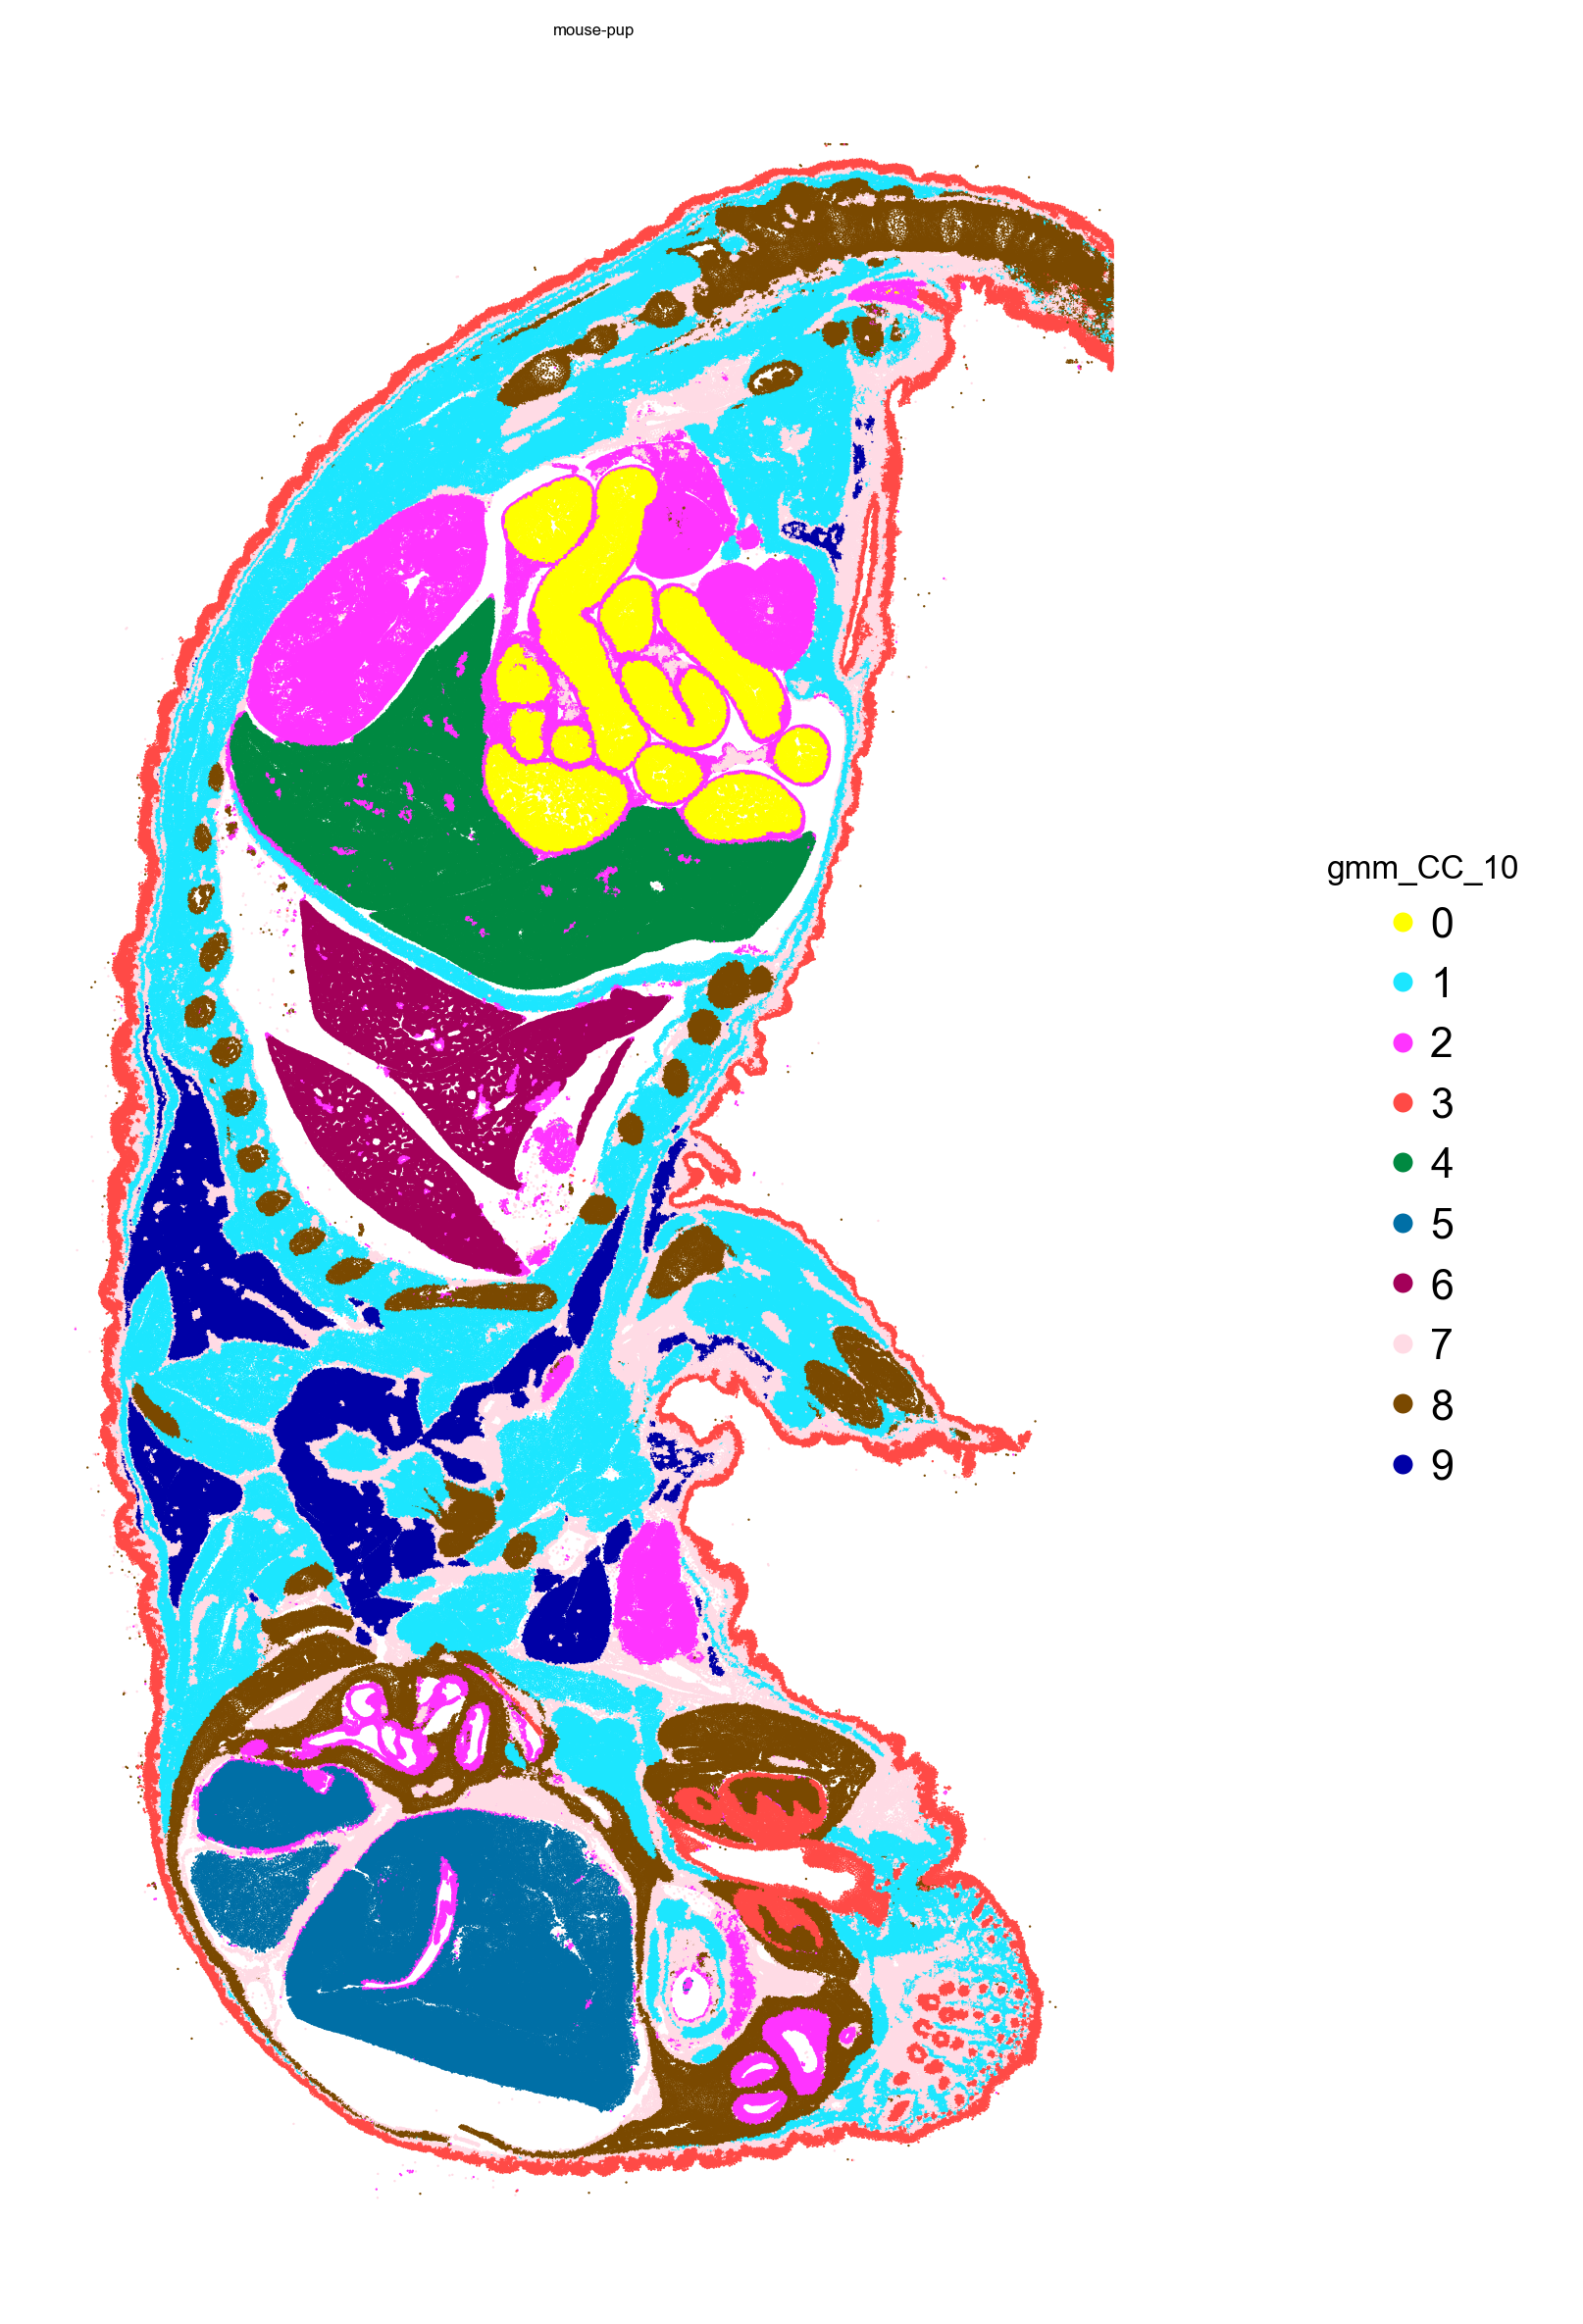

In [40]:
plot_spatial_compact_fast(
    adata,
    color="gmm_CC_10",
    groupby="sample_id",
    spot_size=0.5,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)

In [49]:
import h5py

fn = '/Volumes/processing2/xenium_mouse_embryo/derived_scanpy/step0_clustered.h5ad'
with h5py.File(fn, "r+") as f:
    if "/uns/pca/params" in f:
        del f["/uns/pca/params"]


In [50]:
ad2 = sc.read_h5ad('/Volumes/processing2/xenium_mouse_embryo/derived_scanpy/step0_clustered.h5ad')

In [72]:
ad2.obs.cell_id.astype(str)

0                25220047962113
1                27711128993793
2                44723494453249
3                46312632352769
4                48056389074945
                   ...         
1355844    16777455169548845057
1355845    16777456110146682881
1355846    16777461435906129921
1355847    16777494485679472641
1355848    16777501190123421697
Name: cell_id, Length: 1326723, dtype: object

In [73]:
ad2.obs['gmm_CC_10'] = ad2.obs.cell_id.astype(str).map(dict(zip(adata.obs.index.astype(str), adata.obs['gmm_CC_10'])))
ad2.obs['gmm_CC_15'] = ad2.obs.cell_id.astype(str).map(dict(zip(adata.obs.index.astype(str), adata.obs['gmm_CC_15'])))

In [75]:
plot_spatial_compact_fast(
    ad2,
    color="gmm_CC_15",
    groupby="sample_id",
    spot_size=0.5,
    cols=1,
    height=10,
    background="white",
    dpi=120,
)

ValueError: shape mismatch: value array of shape (0,) could not be broadcast to indexing result of shape (0,4)

In [ ]:
ad2.obs[]